# Titanic Competition Notebook

In this notebook I will be doing in depth data analysis and feature engineering of the Titanic dataset, I will also apply some well-known machine learning model and pick the best model for the submission.

In [1]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Get the Data

In [2]:
import pandas as pd
import numpy as np
import os

TITANIC_PATH = "/kaggle/input/titanic"

def load_data(path = TITANIC_PATH):
    return pd.read_csv(os.path.join(path, "train.csv"), index_col="PassengerId"), pd.read_csv(os.path.join(path, "test.csv"))

In [3]:
train_set, test_set = load_data()

In [4]:
train_set.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
X_train, X_test = train_set.copy(), test_set.copy()
y_train = train_set["Survived"].astype(int)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Data Analysis

## Initial Analysis

Let's check basic information about our data:
* Number of rows and columns.
* Number of missing values in each column.
* Column data types.

In [6]:
print(f"Train set contains {len(X_train)} rows")
print(f"Test set contains {len(X_test)} rows")

Train set contains 891 rows
Test set contains 418 rows


The dataset consists of 891 entries of Training data and 418 entries of Testing data, we will not use validation split on training so we can fully utilize our limited data.

In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Check the missing values:

In [9]:
print("Training missing values:")
missing_values = X_train.isnull().sum()
print(missing_values[missing_values>0])

print("Test missing values:")
missing_values = X_test.isnull().sum()
print(missing_values[missing_values>0])

Training missing values:
Age         177
Cabin       687
Embarked      2
dtype: int64
Test missing values:
Age       86
Fare       1
Cabin    327
dtype: int64


Data type and Missing Values Analysis:
* Age column uses float64 instead of integer.
* Age and Cabin column have the most missing data. We will explore the missing values further and determine the best way to handle them.

## Exploratory Data Analysis
We will do further analysis by exploring relationship and behaviour of our data, we will use this information to help determined the best model.

In [10]:
# Identify object and numerical columns
obj_cols = X_train.describe(include='object').columns.tolist()
num_cols = X_train.describe(include='number').columns.tolist()
print('There are {} object columns'.format(len(obj_cols)))
print(obj_cols)
print('There are {} numerical columns'.format(len(num_cols)))
print(num_cols)

There are 5 object columns
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
There are 6 numerical columns
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [11]:
X_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
X_train.describe(include='number')

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
survability_rate = y_train.value_counts() / len(y_train)
survability_rate

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Behaviour of the data analysis:

* There are no duplicate entries
* Most passangers are males (64.76%)
* The survivability rate is low (38.38%)
* There are possible outliers in SibSp, Parch, and Fare column

We will get better insight by using visualization.

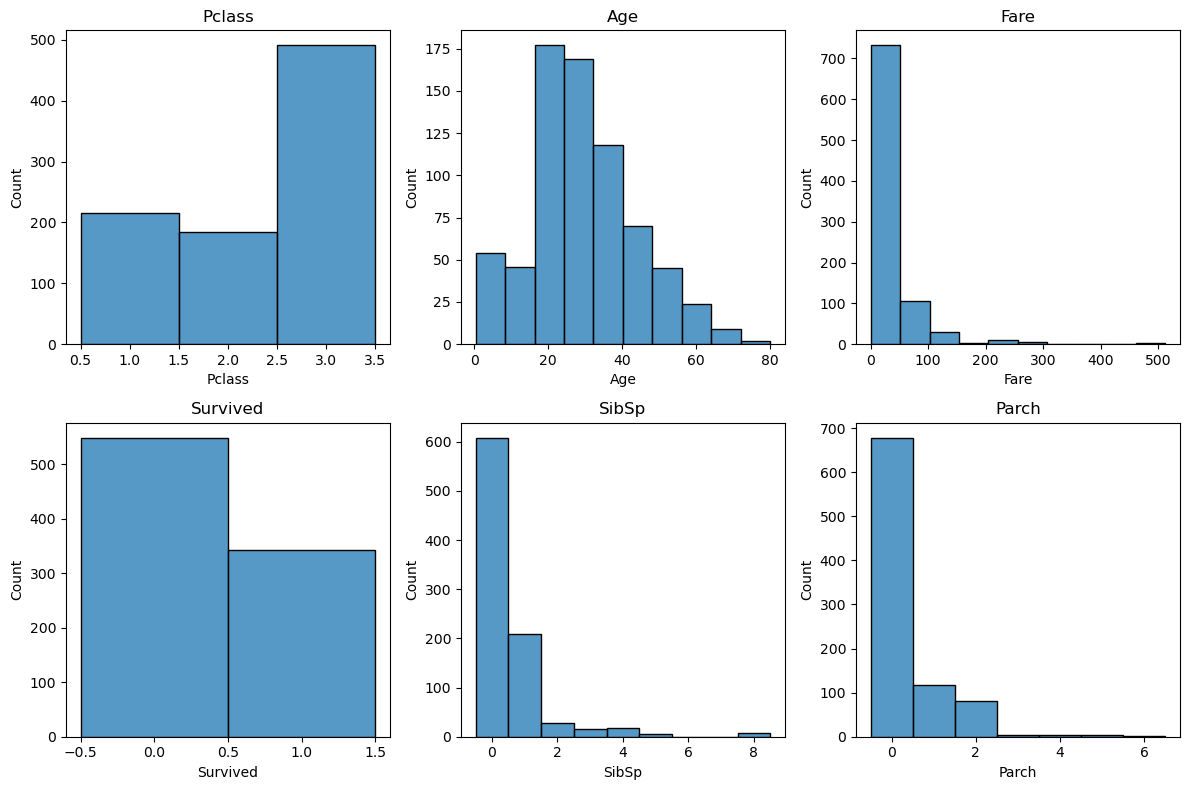

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

sns.histplot(X_train['Pclass'].astype('category'), ax=axes[0,0])
axes[0,0].set_title('Pclass')

sns.histplot(X_train['Age'], bins = 10, ax=axes[0,1])
axes[0,1].set_title('Age')

sns.histplot(X_train['Fare'], bins = 10, ax=axes[0,2])
axes[0,2].set_title('Fare')

sns.histplot(y_train.astype('category'), ax=axes[1,0])
axes[1,0].set_title('Survived')

sns.histplot(X_train['SibSp'].astype('category'), ax=axes[1,1])
axes[1,1].set_title('SibSp')

sns.histplot(X_train['Parch'].astype('category'), ax=axes[1,2])
axes[1,2].set_title('Parch')

plt.tight_layout()

plt.show()

There are an apparent outliers in SibSp, Fare, and Parch columns, let's analyze them further

In [15]:
X_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


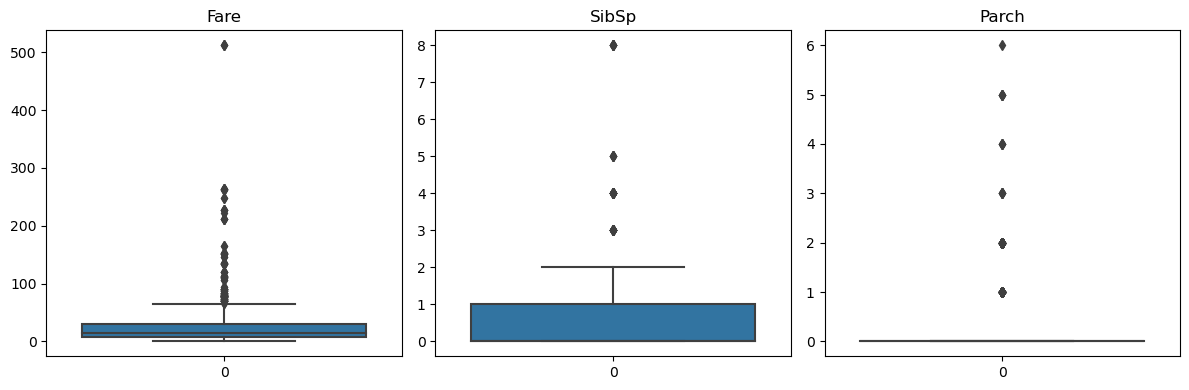

In [16]:

# Outlier detection
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.boxplot(X_train['Fare'],ax=axes[0])
axes[0].set_title('Fare')

sns.boxplot(X_train['SibSp'],ax=axes[1])
axes[1].set_title('SibSp')

sns.boxplot(X_train['Parch'],ax=axes[2])
axes[2].set_title('Parch')

plt.tight_layout()

plt.show()

Based on observation above :

* Fare column have max value of 512.33 while the median is 14.45.
* SibSp column have max value of 8 while the median is 0.
* Parch column have max value of 6 while median is 0.

The outliers in Fare and SibSp columns are significant, we might have to handle this to reduce noise in our training data.

### Analyze SibSp and Parch columns
SibSp and Parch of a passanger correlate to the number of how many other passangers are abroad which have familial bond wether ts Sibling/Spouse or Parent/Children.

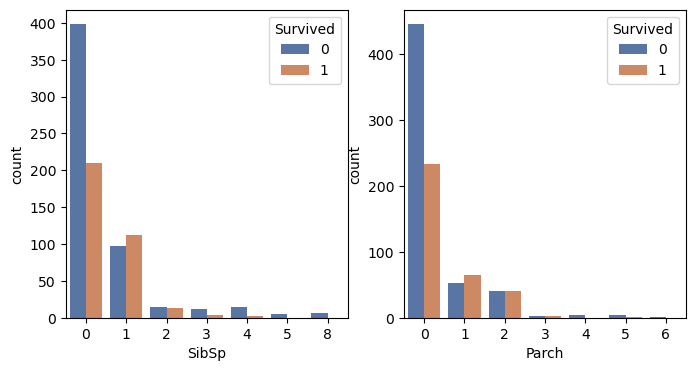

<Figure size 640x480 with 0 Axes>

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.countplot(x=X_train['SibSp'].astype('category'),
              hue=y_train, 
              palette='deep',ax=axes[0])
sns.countplot(x=X_train['Parch'].astype('category'),
              hue=y_train, 
              palette='deep',ax=axes[1])
plt.show()
plt.tight_layout()

Text(0.5, 1.0, 'Combination of SibSp and Parch Frequency plot')

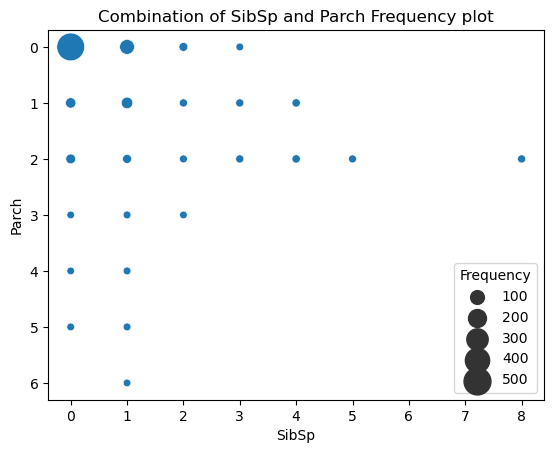

In [18]:
frequency = X_train.groupby(['SibSp', 'Parch']).size().reset_index(name='Frequency')
sns.scatterplot(x=frequency['SibSp'].astype('category'),
                y=frequency['Parch'].astype('category'),
                size=frequency['Frequency'], 
                sizes=(30,400)).set_title('Combination of SibSp and Parch Frequency plot')

Based on observation above :

* There are some portion of passangers that is alone (SibSp = 0, Parch = 0)
* The distribution of SibSp and Parch are similiar
* We can use both column to generate a more useful feature

Our new feature is as followed :

* When there are 0 SibSp and 0 Parch labeled Is_Alone
* SibSp + Parch + 1 labeled Group_Size

In [19]:
# Generating feature for train and test
for df in [X_train, X_test] :
    df['Have_Parch'] = df['Parch'].apply(lambda x: 1 if x > 0 else 0).astype(int)
    df['Have_SibSp'] = df['SibSp'].apply(lambda x: 1 if x > 0 else 0).astype(int)
    df['Is_Alone'] = df.apply(lambda row: 1 if row['SibSp'] + row['Parch'] == 0 else 0, axis=1).astype(int)
    df['Group_Size'] = (df['SibSp']+df['Parch']+1).astype(int)

To handle the outliers, we will bin the **Group_Size** feature into bins to remove noise in the data

In [20]:
# Bin the group to 4 different categories
group_bins = [0, 1, 4, 6, 12]
for df in [X_train, X_test]:
    df['Group_Category'] = pd.cut(df['Group_Size'], 
                                  bins=group_bins, 
                                  labels=['Alone', 'Small', 'Medium', 'Large'])
    df['Group_Category'] = df['Group_Category'].map({'Alone':0,'Small':1,'Medium':2,'Large':3}).astype(int)

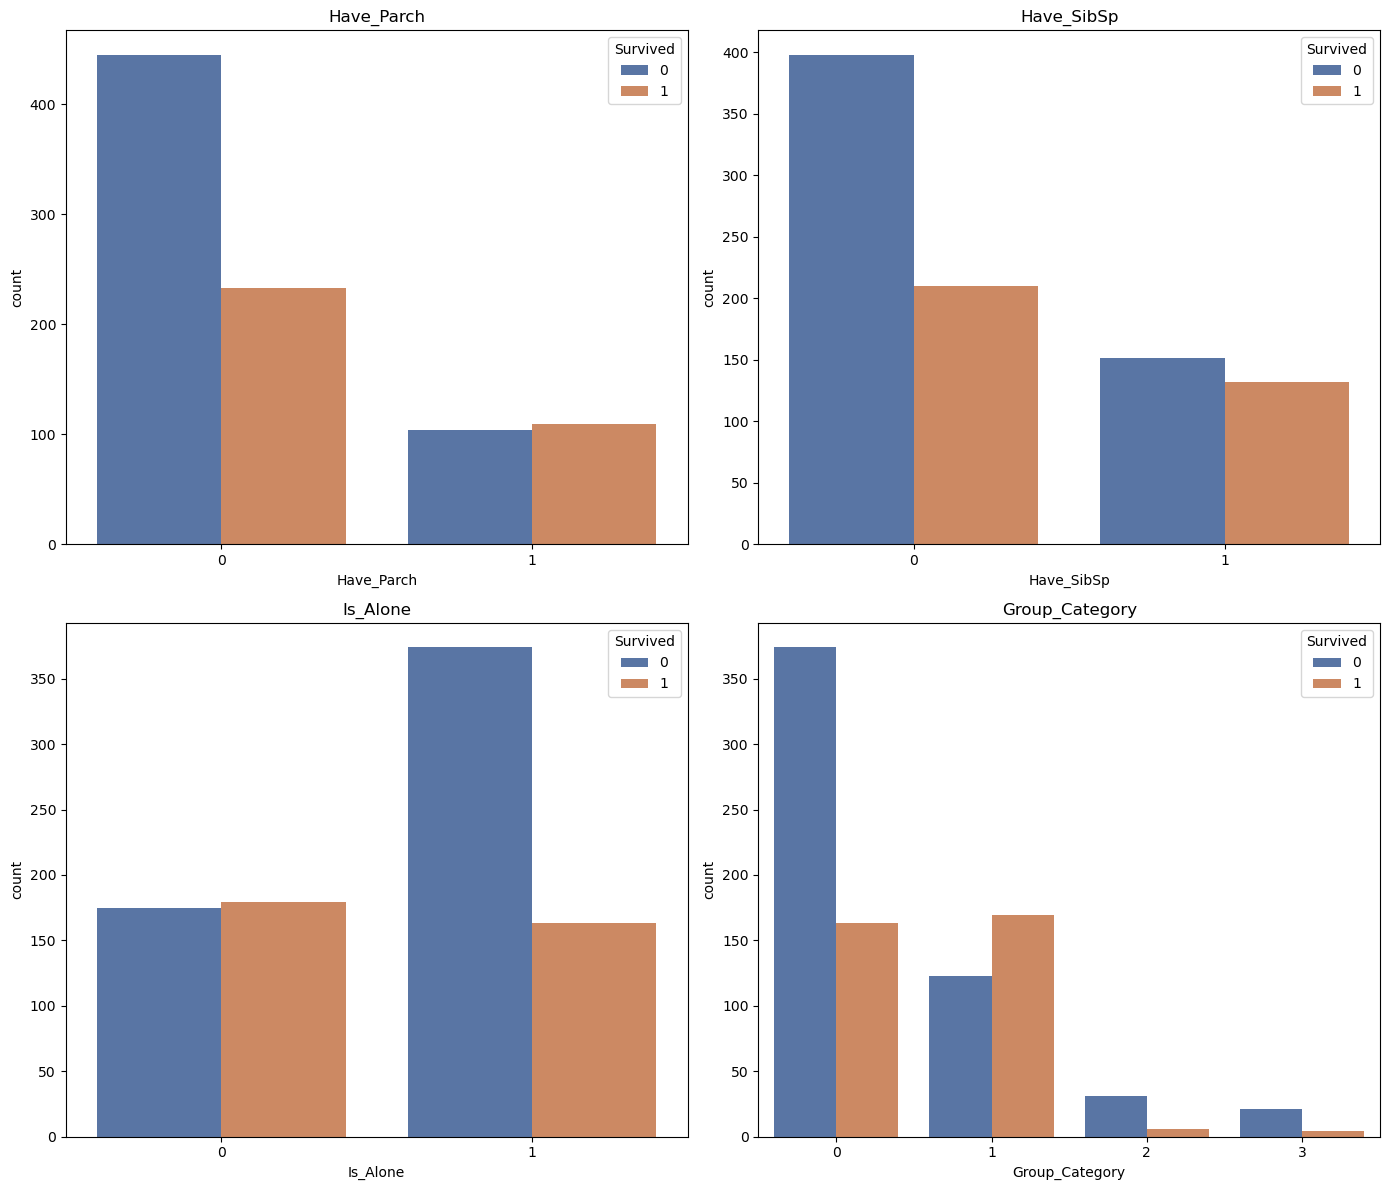

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

sns.countplot(x=X_train['Have_Parch'], hue=X_train['Survived'], ax=axes[0,0], palette='deep')
axes[0,0].set_title('Have_Parch')

sns.countplot(x=X_train['Have_SibSp'], hue=X_train['Survived'], ax=axes[0,1], palette='deep')
axes[0,1].set_title('Have_SibSp')

sns.countplot(x=X_train['Is_Alone'], hue=X_train['Survived'], ax=axes[1,0], palette='deep')
axes[1,0].set_title('Is_Alone')

sns.countplot(x=X_train['Group_Category'], hue=X_train['Survived'], ax=axes[1,1], palette='deep')
axes[1,1].set_title('Group_Category')

plt.tight_layout()

plt.show()

Passangers with small group size **(2-4 people)** tends to survive compared to other group size ranges

<Axes: >

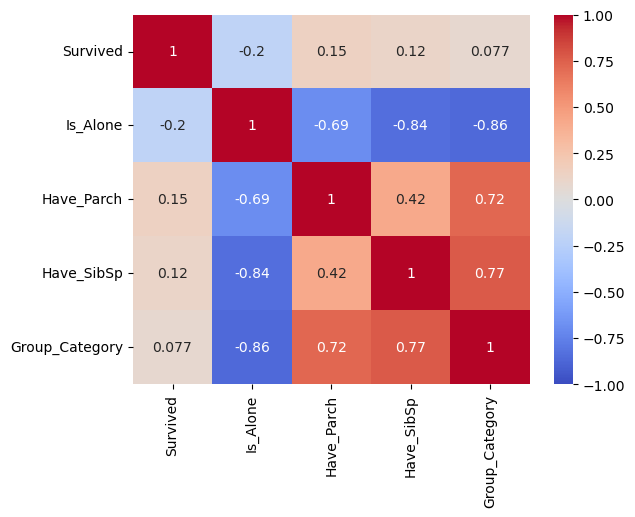

In [22]:
columns = ['Survived','Is_Alone','Have_Parch','Have_SibSp','Group_Category']
sns.heatmap(X_train[columns].corr(), vmax=1,vmin=-1, annot=True, cmap='coolwarm')

### Analyze Age column
The Age value of a passanger might affect their survivability. In a disaster, most life saving equipments are prioritized to children and older people. There are some missing values in this column (both in the training and test set). We will fill these missing values with the mean age of the person's title. For that, let's obtain the **title** feature:

#### Extract Title from Name
A title can be represented with a single word with a dot (.) in the end, we will use **RegEx** to find them
We can use Pandas **str.extract** method to apply RegEx on entire column:

In [23]:
# Apply RegEx pattern to extract title
pattern = ' ([A-Za-z]+)\.'
for df in [X_train, X_test] :
    df['Title'] = df['Name'].str.extract(pattern)

In [24]:
print(X_train['Title'].unique())
print(X_test['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [25]:
title_mean_age = X_train.groupby('Title')['Age'].mean().round(decimals=1)
display(title_mean_age.to_frame().T)

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Age,70.0,58.0,33.0,40.0,42.0,38.0,48.0,48.5,4.6,21.8,24.0,24.0,32.4,35.9,28.0,43.2,49.0


In [26]:
title_mean_age

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Jonkheer    38.0
Lady        48.0
Major       48.5
Master       4.6
Miss        21.8
Mlle        24.0
Mme         24.0
Mr          32.4
Mrs         35.9
Ms          28.0
Rev         43.2
Sir         49.0
Name: Age, dtype: float64

In [27]:
titles = pd.concat([X_train['Title'], X_test['Title']]).unique()
for df in [X_train, X_test]:
    for title in titles:
        if title in title_mean_age.index:
            df.loc[(df['Title'] == title) & df['Age'].isnull(), 'Age'] = title_mean_age[title]
        else:
            df.loc[(df['Title'] == title) & df['Age'].isnull(), 'Age'] = X_train['Age'].median()

In [28]:
# Bin age to remove abnormal values and remove noise
age_bins = [0, 5, 20, 30, 40, 50, 60, 100]
for df in [X_train, X_test]:
    df['Age_Category'] = pd.cut(df['Age'], 
                                bins=age_bins, 
                                labels=['Infant', 'Teen', '20s', '30s', '40s', '50s', 'Elderly'])

<Axes: xlabel='Age_Category', ylabel='Survived'>

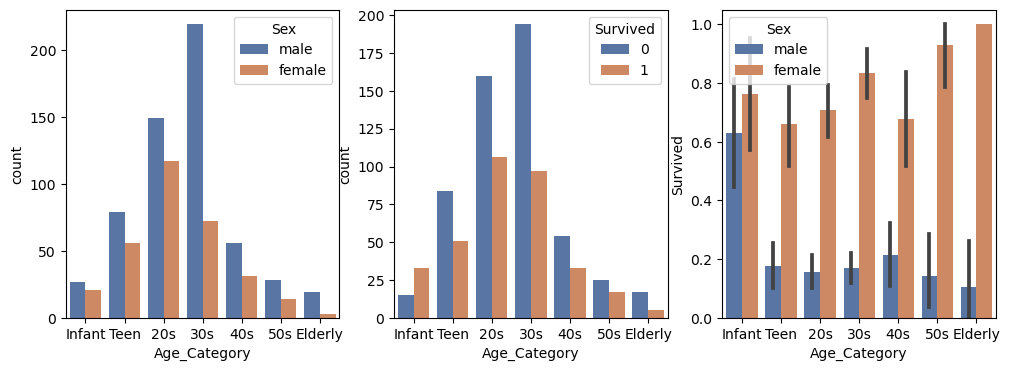

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.countplot(x=X_train['Age_Category'], hue=X_train['Sex'], palette='deep', ax=axes[0])
sns.countplot(x=X_train['Age_Category'], hue=y_train, palette='deep', ax=axes[1])
sns.barplot(x=X_train['Age_Category'], y=y_train, hue=X_train['Sex'], palette='deep')

We can conclude that :

* Most passangers are Grown Ups (Age range 20-30)
* Infants have the most survivability rate
* In all range of ages, male have higher count
* In all range of ages, female have higher survivability

### Analyze Fare columns
The Fare value of a passanger denotes the price of the trip for each passangers. There are some Passangers that have the same Fares, this shows that for the price paid might be a Total Fare instead of an Individual Fare.

The correlation between **Fare** and **Pclass** is really high.

In [30]:
X_train.corr(numeric_only=True).abs()['Fare'].sort_values(ascending=False).to_frame().style.background_gradient(cmap='Reds')

,Fare
Fare,1.000000
Pclass,0.549500
Is_Alone,0.271832
Survived,0.257307
Group_Category,0.249544
Have_Parch,0.237717
Group_Size,0.217138
Parch,0.216225
Have_SibSp,0.192190
SibSp,0.159651


There is a missing value in the test set in the Fare column.

In [31]:
# Get the entry with missing Fare values
X_test[X_test['Fare'].isna()][['Pclass','Sex','Is_Alone','Age_Category']]

,Pclass,Sex,Is_Alone,Age_Category
152,3,male,1,Elderly


We will calculate the median using the four column Pclass, Sex, Is_Alone, and Age_Category

In [32]:
selected_column = ['Pclass','Sex','Is_Alone','Age_Category']
mean_fare = X_train.groupby(selected_column)['Fare'].mean().to_frame().reset_index()

In [33]:
mean_fare

,Pclass,Sex,Is_Alone,Age_Category,Fare
0,1,female,0,Infant,151.550000
1,1,female,0,Teen,116.502655
2,1,female,0,20s,153.037500
3,1,female,0,30s,88.543474
4,1,female,0,40s,121.512514
...,...,...,...,...,...
79,3,male,1,20s,9.508835
80,3,male,1,30s,10.383256
81,3,male,1,40s,7.314817
82,3,male,1,50s,7.630840


In [34]:
# We manually replace the missing values by finding the correct mean value
replacement_fare = mean_fare[(mean_fare['Pclass']==3) & (mean_fare['Sex']=='male') & (mean_fare['Is_Alone']==1) & (mean_fare['Age_Category']=='Elderly')]['Fare']
print('We will replace the missing value with {}'.format(replacement_fare.values[0]))

We will replace the missing value with 7.378125


In [35]:
# Replace the said missing values
X_test['Fare'] = X_test['Fare'].fillna(replacement_fare.values[0])

In [36]:
# Generate Fare Individual column
for df in [X_train,X_test]:
    df['Fare_Individual'] = df['Fare']/df['Group_Size']
    df.rename(columns={'Fare': 'Fare_Total'},inplace=True)
    df[['Fare_Total','Fare_Individual']] = df[['Fare_Total','Fare_Individual']].round(2).astype(float)

<Axes: xlabel='Group_Size', ylabel='Fare_Individual'>

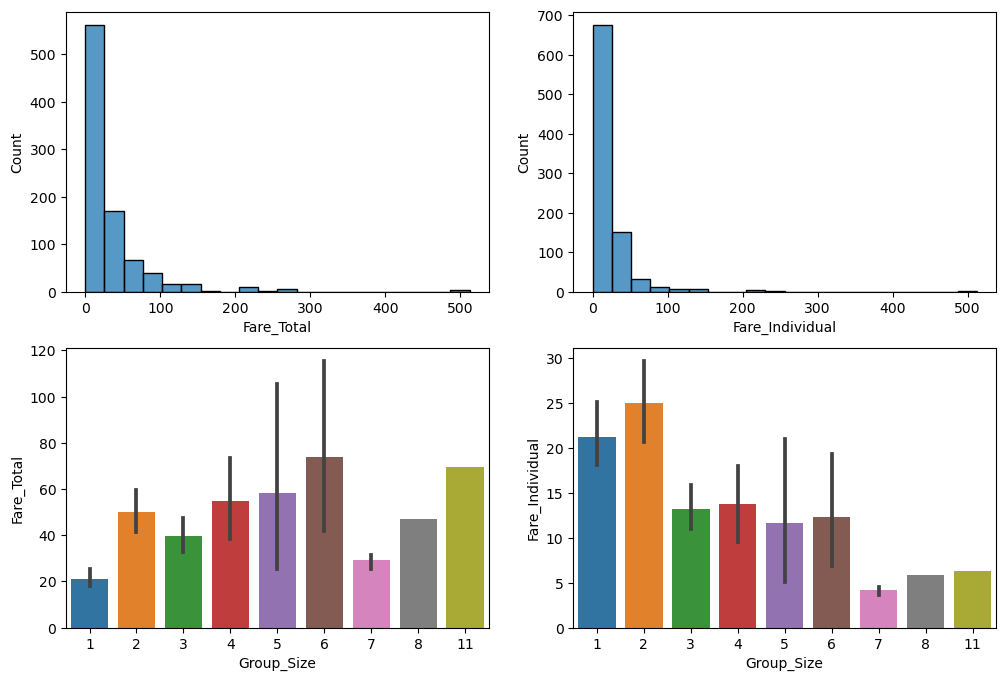

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.histplot(X_train['Fare_Total'],  bins=20, ax=axes[0,0])
sns.histplot(X_train['Fare_Individual'],  bins=20, ax=axes[0,1])
sns.barplot(x=X_train['Group_Size'], y=X_train['Fare_Total'], ax=axes[1,0])
sns.barplot(x=X_train['Group_Size'], y=X_train['Fare_Individual'], ax=axes[1,1])

We will bin the fare values to remove noise and handle outliers

In [38]:
X_train['Fare_Total_Bins'] = pd.qcut(X_train['Fare_Total'], 6)
pd.qcut(X_train['Fare_Total'], 6).unique()

[(-0.001, 7.78], (52.367, 512.33], (7.78, 8.66], (26.0, 52.367], (14.45, 26.0], (8.66, 14.45]]
Categories (6, interval[float64, right]): [(-0.001, 7.78] < (7.78, 8.66] < (8.66, 14.45] < (14.45, 26.0] < (26.0, 52.367] < (52.367, 512.33]]

In [39]:
X_train['Fare_Indiv_Bins'] = pd.qcut(X_train['Fare_Individual'], 6)
pd.qcut(X_train['Fare_Individual'], 6).unique()

[(-0.001, 6.75], (29.7, 512.33], (7.78, 8.3], (13.0, 29.7], (8.3, 13.0], (6.75, 7.78]]
Categories (6, interval[float64, right]): [(-0.001, 6.75] < (6.75, 7.78] < (7.78, 8.3] < (8.3, 13.0] < (13.0, 29.7] < (29.7, 512.33]]

In [40]:
# Bin the Fare Total and Fare Individual columns
for df in [X_train,X_test] :
    df.loc[ df['Fare_Total'] <= 7.78, 'Fare_Total'] = 0
    df.loc[(df['Fare_Total'] > 7.78) & (df['Fare_Total'] <= 8.66), 'Fare_Total'] = 1
    df.loc[(df['Fare_Total'] > 8.66) & (df['Fare_Total'] <= 14.45), 'Fare_Total'] = 2
    df.loc[(df['Fare_Total'] > 14.45) & (df['Fare_Total'] <= 26.0), 'Fare_Total'] = 3
    df.loc[(df['Fare_Total'] > 26.0) & (df['Fare_Total'] <= 52.37), 'Fare_Total'] = 4
    df.loc[ df['Fare_Total'] > 52.37, 'Fare_Total'] = 5
    df['Fare_Total'] = df['Fare_Total'].astype(int)

    df.loc[ df['Fare_Individual'] <= 6.75, 'Fare_Individual'] = 0
    df.loc[(df['Fare_Individual'] > 6.75) & (df['Fare_Individual'] <= 7.78), 'Fare_Individual'] = 1
    df.loc[(df['Fare_Individual'] > 7.78) & (df['Fare_Individual'] <= 8.3), 'Fare_Individual'] = 2
    df.loc[(df['Fare_Individual'] > 8.3) & (df['Fare_Individual'] <= 13.0), 'Fare_Individual'] = 3
    df.loc[(df['Fare_Individual'] > 13.0) & (df['Fare_Individual'] <= 29.7), 'Fare_Individual'] = 4
    df.loc[ df['Fare_Individual'] > 29.7, 'Fare_Individual'] = 5
    df['Fare_Individual'] = df['Fare_Individual'].astype(int)

In [41]:
X_train = X_train.drop(['Fare_Total_Bins','Fare_Indiv_Bins'], axis=1)

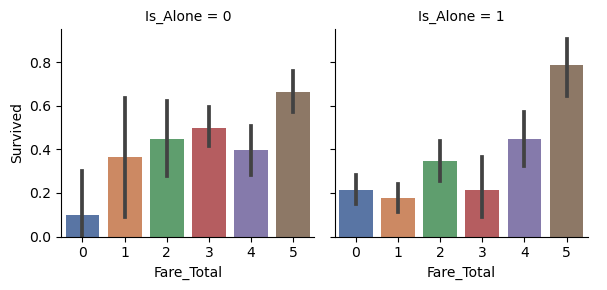

In [42]:
grid = sns.FacetGrid(X_train, col='Is_Alone')
grid.map(sns.barplot, 'Fare_Total', 'Survived', palette='deep')
grid.add_legend()

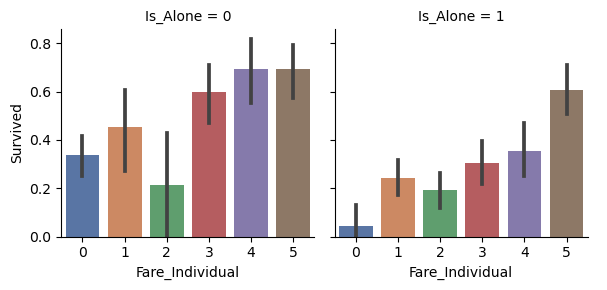

In [43]:
grid = sns.FacetGrid(X_train, col='Is_Alone')
grid.map(sns.barplot, 'Fare_Individual', 'Survived', palette='deep')
grid.add_legend()

<Axes: >

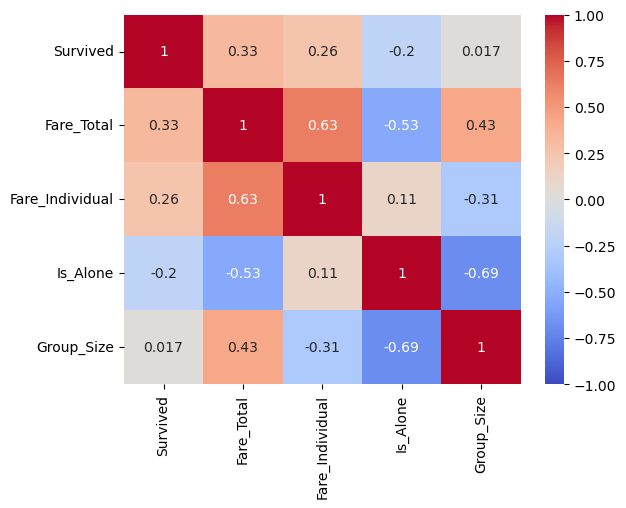

In [44]:
columns = ['Survived','Fare_Total','Fare_Individual','Is_Alone','Group_Size']
sns.heatmap(X_train[columns].corr(), vmax=1,vmin=-1, annot=True, cmap='coolwarm')

Using the heatmap and analysis above we can see that:

* both **Total Fare** and **Individual Fare** are good predictors for **Survived** columns
* **Total Fare** and **Individual Fare** are correlated but have different relationship on **Group Size** or **Is Alone**

### Analyze Categorical Features (Name, Sex, Ticket, Cabin, and Embarked)

In [45]:
# Replace unique titles with selected titles
for df in [X_train,X_test] :
    df['Title'] = df['Title'].replace(['Capt', 'Col','Don','Major', 'Rev', 'Sir'], 'Rare_Males')
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Dona'], 'Rare_Females')
    df['Title'] = df['Title'].replace(['Dr', 'Rev','Jonkheer'], 'Rare_Unisex')
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

<Axes: xlabel='Title', ylabel='Survived'>

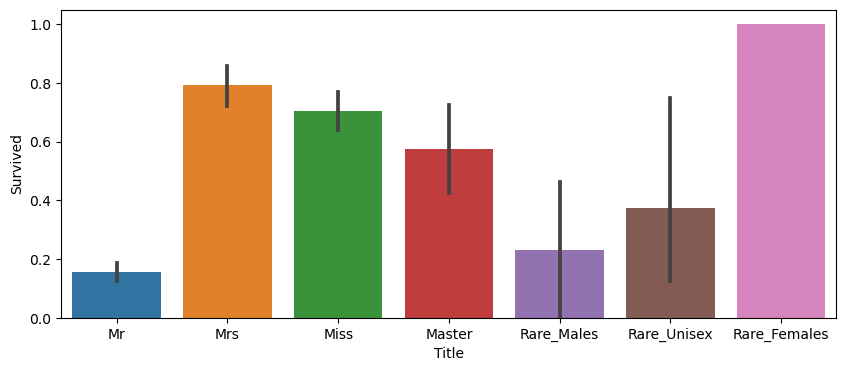

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=X_train['Title'],y=X_train['Survived'])

In [47]:
X_train = X_train.drop(columns=['Name'])
X_test = X_test.drop(columns=['Name'])

The **Title** feature extracted from passanger names is a good predictor:

* Each entries title are successfully extracted
* Mr. is the title with the most count have the lowest survivability
* The Rare title consist of combination of male and female titles

#### Analyze Ticket Features
For ticket column, we will use RegEx to extract information.

The number will ignored and the first character of a word will be extracted.

In [48]:
# Appy RegEx pattern to extract the ticket type
# We ignore numbers and extract every first character on a single entries
# We Replace words like STON or PARIS with their first letter S or P
pattern = '([A-Z\.\/]*).* [0-9]*'
for df in [X_train, X_test] :
    Ticket_Extract = df['Ticket'].str.extract(pattern).reset_index()
    Ticket_Clean = Ticket_Extract[0].astype(str).str.split('[./]').apply(lambda x: [i.strip() for i in x if i.strip()])
    Ticket_Clean = Ticket_Clean.apply(lambda x: ['S' if item in ['STON', 'SOTON'] else item for item in x])
    Ticket_Clean = Ticket_Clean.apply(lambda x: ['P' if item in ['PARIS'] else item for item in x])
    Ticket_Clean = Ticket_Clean.apply(lambda x: list(set(''.join(x))))
    
    # Generate features corresponding to each ticket type
    df.reset_index(drop=True, inplace=True)
    df['TicketA'] = Ticket_Clean.apply(lambda x: int('A' in x))
    df['TicketP'] = Ticket_Clean.apply(lambda x: int('P' in x))
    df['TicketC'] = Ticket_Clean.apply(lambda x: int('C' in x))
    df['TicketS'] = Ticket_Clean.apply(lambda x: int('S' in x))
    df['TicketQ'] = Ticket_Clean.apply(lambda x: int('Q' in x))
    df['TicketO'] = Ticket_Clean.apply(lambda x: int('O' in x))
    df['TicketW'] = Ticket_Clean.apply(lambda x: int('W' in x))
    df['Have_Ticket'] = Ticket_Clean.apply(lambda x: int(any(['A' in x, 'P' in x, 'C' in x, 'S' in x, 'Q' in x, 'O' in x, 'W' in x])))

In [49]:
# Get the count of every unique ticket type
columns = ['TicketQ','TicketW','TicketO','TicketA','TicketS','TicketP','TicketC','Have_Ticket']
for column in columns:
    print('column {} have {} entries'.format(column,X_train[column].sum()))

column TicketQ have 15 entries
column TicketW have 16 entries
column TicketO have 46 entries
column TicketA have 75 entries
column TicketS have 67 entries
column TicketP have 86 entries
column TicketC have 146 entries
column Have_Ticket have 225 entries


Because of small number of entries we will group the tickets types

In [50]:
# Relation of each ticket type to Survivability
X_train[['TicketQ','TicketW','TicketO','TicketA','TicketS','TicketP','TicketC','Have_Ticket','Survived']].corr()['Survived'].sort_values()

TicketA       -0.089668
TicketO       -0.069426
TicketQ       -0.067404
TicketS       -0.041282
TicketW       -0.037215
Have_Ticket    0.003380
TicketC        0.080801
TicketP        0.132777
Survived       1.000000
Name: Survived, dtype: float64

Based on the correlation, we can group ticket A,O,Q,S,W into **type1** and ticket P and C into **type2**

In [51]:
# Group ticket into type1 and type2
for df in [X_train,X_test] :
    df['Ticket_Type1'] = df['TicketQ'] | df['TicketW'] | df['TicketO'] | df['TicketA'] | df['TicketS']
    df['Ticket_Type2'] = df['TicketP'] | df['TicketC']

<Axes: xlabel='Ticket_Type2', ylabel='count'>

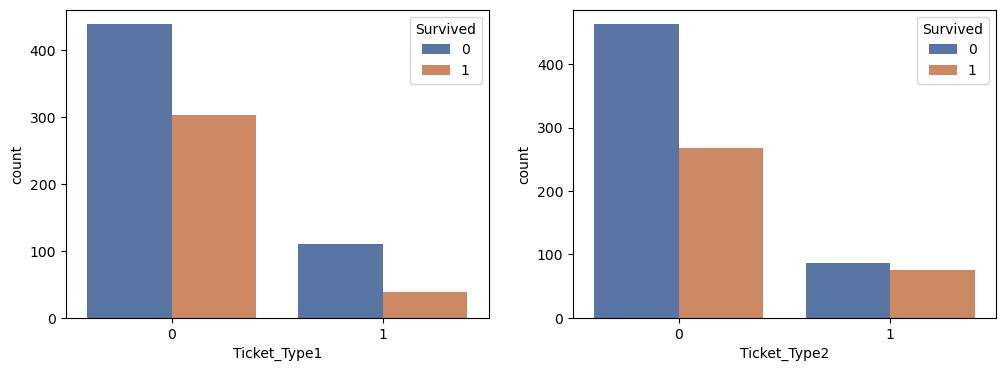

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x=X_train['Ticket_Type1'],hue=X_train['Survived'],ax=axes[0], palette='deep')
sns.countplot(x=X_train['Ticket_Type2'],hue=X_train['Survived'],ax=axes[1], palette='deep')

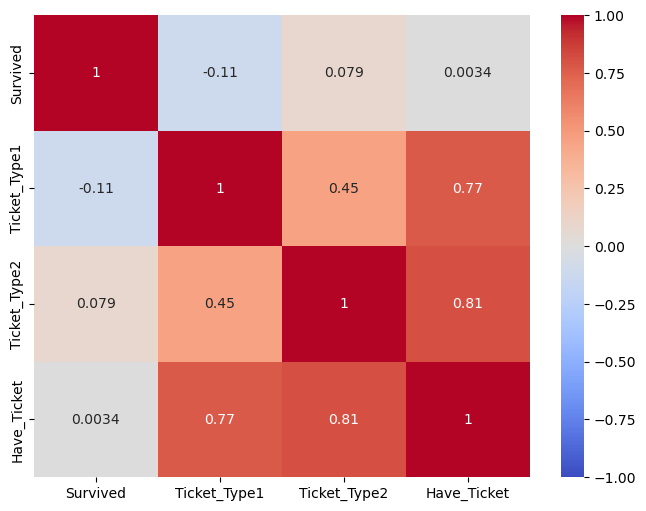

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
columns = ['Survived','Ticket_Type1','Ticket_Type2','Have_Ticket']
correlation_matrix = X_train[columns].corr()
sns.heatmap(correlation_matrix, vmax=1,vmin=-1, annot=True, cmap='coolwarm')

plt.show()

In [54]:
X_train.drop(columns=['Ticket','TicketA', 'TicketP', 'TicketC', 'TicketS', 'TicketQ', 'TicketO', 'TicketW','Have_Ticket'], inplace=True)
X_test.drop(columns=['Ticket','TicketA', 'TicketP', 'TicketC', 'TicketS', 'TicketQ', 'TicketO', 'TicketW','Have_Ticket'], inplace=True)

The **Ticket** feature might not provide meaningful information:

* There are only 206 entries which the ticket type can be extracted.
* The correlation between each ticket type and survivability is low.
* We grouped ticket type1 as (Q,W,O,A,S) and ticket type2 as (P,C).

#### Analyze Cabin feature
* The cabin feature have the most missing values in both training and testing data, dropping the column is a good option
* Some entries have multiple cabins listed
* The structure of the data is the cabin type and the cabin ID, e.g. C85

<Axes: xlabel='Cabin', ylabel='Survived'>

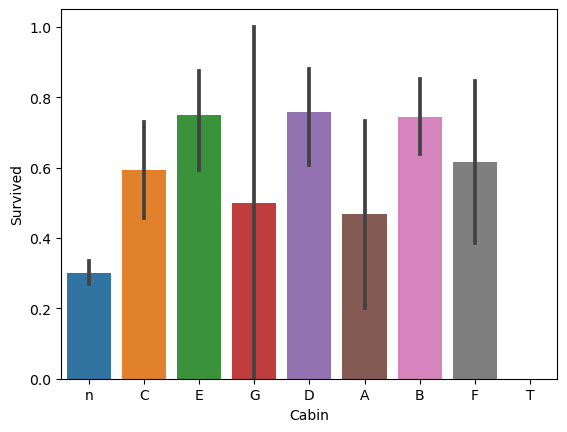

In [55]:
sns.barplot(x=X_train['Cabin'].astype(str).apply(lambda x: x[0]),y=X_train['Survived'])

In [56]:
# Extract the first letter from the Cabin column
for df in[X_train,X_test] :
    df['Cabin'] = df['Cabin'].astype(str).apply(lambda x: x[0])
    df['Cabin'] = df['Cabin'].replace(['A','F','G','T'],'Other')
    df['Cabin'] = df['Cabin'].replace(['n'],'Unlisted')

<Axes: xlabel='Cabin', ylabel='count'>

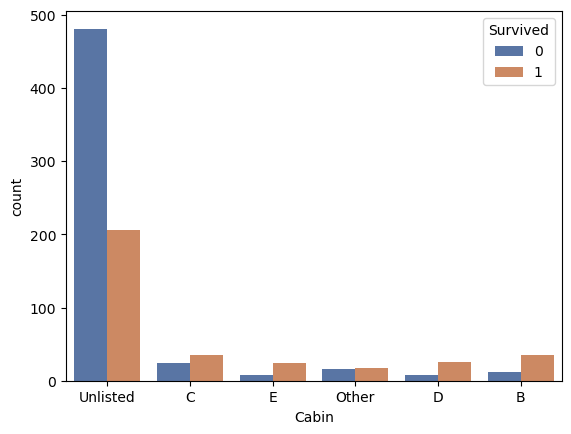

In [57]:
sns.countplot(x=X_train['Cabin'],hue=X_train['Survived'], palette='deep')

The **Cabin** feature might provide meaningful information

* There are 671 unlisted entries, mostly not survive
* The cabin with most entries are C,B,D, and E. Each have rather high survivability
* The cabin with lesser entries are grouped into other, is not a good predictor

#### Analyze Embarked feature
* Embarked values are mostly categorical with 3 distinct values
* Training data have a missing value, can be replaced by mode

In [58]:
frequent_embarked = X_train['Embarked'].mode()[0]
print('We will replace the missing value with {}'.format(frequent_embarked))

We will replace the missing value with S


In [59]:
X_train['Embarked'] = X_train['Embarked'].fillna(frequent_embarked)

<Axes: xlabel='Embarked', ylabel='count'>

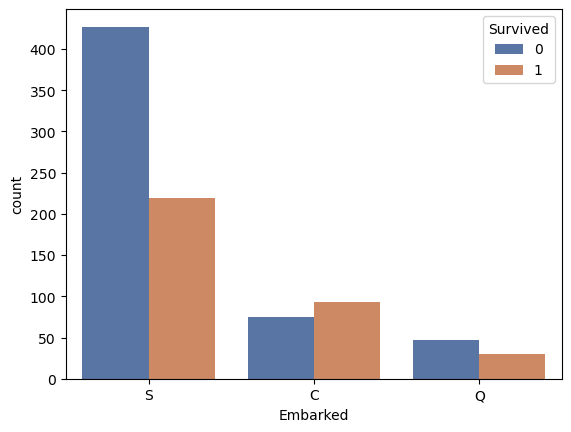

In [60]:
sns.countplot(x=X_train['Embarked'],hue=X_train['Survived'], palette='deep')

# Feature Engineering and Data Encoding

In [61]:
# Map the Sex and Age Category columns into numerical value
# We use discrete value because the age category is still a continuous value
for df in [X_train,X_test] :
    df['Age_Category'] = df['Age_Category'].map({'Infant':0,'Teen':1,'20s':2,'30s':3,'40s':4,'50s':5,'Elderly':6})

In [62]:
# We one-hot-encode categorical values into separate columns
X_train = pd.get_dummies(X_train, columns=['Cabin','Embarked','Title','Sex'])
X_test = pd.get_dummies(X_test, columns=['Cabin','Embarked','Title','Sex'])

In [63]:
# Drop unnecessary columns
X_train = X_train.drop(columns=['Group_Size'])
X_test = X_test.drop(columns=['Group_Size'])

In [64]:
corr_matrix = X_train.corr()
print(corr_matrix["Survived"].sort_values(ascending=False))

Survived              1.000000
Sex_female            0.543351
Title_Mrs             0.341994
Title_Miss            0.335636
Fare_Total            0.325626
Fare_Individual       0.256569
Cabin_B               0.175095
Embarked_C            0.168240
Cabin_D               0.150716
Have_Parch            0.147408
Cabin_E               0.145321
Have_SibSp            0.115867
Cabin_C               0.114652
Title_Master          0.085221
Parch                 0.081629
Ticket_Type2          0.079185
Group_Category        0.077333
Title_Rare_Females    0.060095
Cabin_Other           0.052954
Embarked_Q            0.003650
Title_Rare_Unisex    -0.001730
SibSp                -0.035322
Title_Rare_Males     -0.038299
Age                  -0.089270
Ticket_Type1         -0.112502
Embarked_S           -0.149683
Is_Alone             -0.203367
Cabin_Unlisted       -0.316912
Pclass               -0.338481
Sex_male             -0.543351
Title_Mr             -0.549199
Name: Survived, dtype: float64


In [65]:
# Remove column with less than 0.05 correlation with Survived
columns_to_remove = []
corr = X_train.corr()['Survived']

for column in corr.index.drop('Survived') :
    if(abs(corr.loc[column])<0.05):
        columns_to_remove.append(column)

print('Columns to be removed :')
print(columns_to_remove)
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)

Columns to be removed :
['SibSp', 'Embarked_Q', 'Title_Rare_Males', 'Title_Rare_Unisex']


<Axes: >

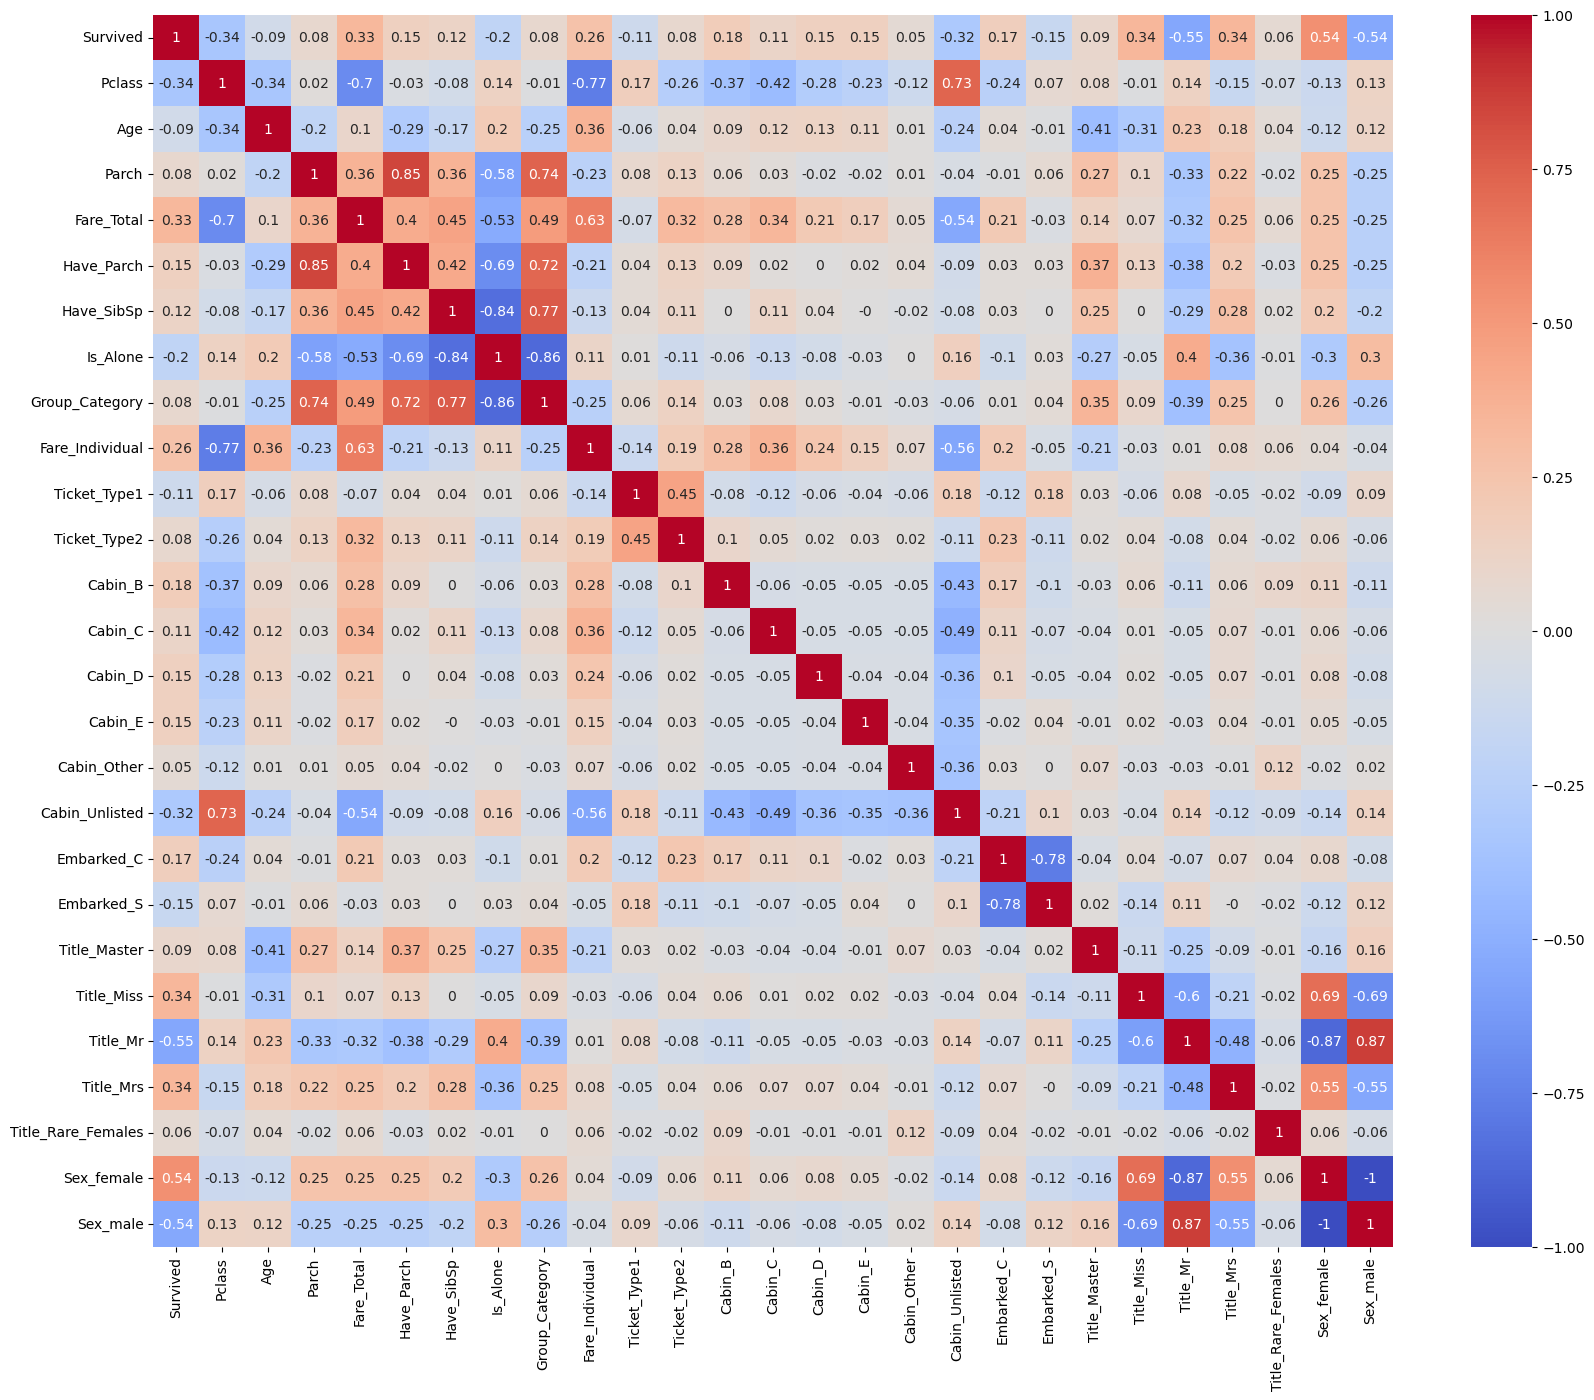

In [66]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(round(X_train.corr(),2),vmax=1,vmin=-1, annot=True, cmap='coolwarm')

# Creating Prediction Models

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [68]:
X_train = X_train.drop("Survived", axis=1).astype(float)
X_test.drop(["PassengerId"], axis=1, inplace=True)

In [69]:
# Normalize both train and test input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model 1. **Logistic Regression**

In [70]:
param_grid = {
    'penalty': ['l1', 'l2'],  # regularization penalty (L1 or L2)
    'C': np.logspace(-4, 4, 20),  # inverse regularization strength
    'solver': ['liblinear']  # optimization algorithm
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy', 
    n_jobs=-1,
    verbose = True
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
logreg_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Accuracy Score: ", logreg_score)

best_logreg = LogisticRegression(random_state=42,
                                 penalty=best_params['penalty'],
                                 C=best_params['C'],
                                 solver=best_params['solver']).fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best Parameters:  {'C': 0.615848211066026, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy Score:  0.8283033080158182


## Model 2. **Gradient Boost**

In [71]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.025, 0.01],
    'n_estimators': [10, 30, 50, 80, 100],
    'max_depth': [3, 5, 7, 10]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,  
    verbose = True
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
gbk_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Accuracy Score: ", gbk_score)

best_gbk = GradientBoostingClassifier(random_state=42,
                                      learning_rate=best_params['learning_rate'],
                                      n_estimators=best_params['n_estimators'],
                                      max_depth=best_params['max_depth']).fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Best Accuracy Score:  0.841748791664051


## Model 3. **Random Forest**

In [72]:
param_grid = {
    'n_estimators': [10, 30, 50, 80, 100],
    'max_depth': [2,4,6,8,10],
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['Auto','sqrt']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy', 
    n_jobs=-1,  
    verbose = True
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
rf_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Accuracy Score: ", rf_score)

best_rf = RandomForestClassifier(random_state=42,
                                 n_estimators=best_params['n_estimators'],
                                 criterion = best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 max_features = best_params['max_features']).fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 80}
Best Accuracy Score:  0.8327788588286987


## Model 4. **Decision Trees**

In [73]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,None],
    'max_features' : ['Auto','sqrt']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy', 
    n_jobs=-1,  
    verbose = True
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
dt_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Accuracy Score: ", dt_score)

best_dt = DecisionTreeClassifier(random_state=42,
                                 criterion = best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 max_features=best_params['max_features']).fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt'}
Best Accuracy Score:  0.8125980792166217


## Model 5. **SVC**

In [74]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
} 

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy', 
    n_jobs=-1,  
    verbose = True
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
svc_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Accuracy Score: ", svc_score)

best_svc = SVC(random_state=42,
               C = best_params['C'],
               gamma=best_params['gamma'],
               kernel=best_params['kernel']).fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy Score:  0.8305442219571905


### Model Performance Summary

In [75]:
models = pd.DataFrame({
    'Model': ['Logistic Regression (Base)', 'Gradient Boosting Classifier','SVC',
             'Decision Tree Classifier', 'Random Forest Classifier'],
    'Score': [logreg_score, gbk_score, svc_score,dt_score, rf_score]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Gradient Boosting Classifier,0.841749
4,Random Forest Classifier,0.832779
2,SVC,0.830544
0,Logistic Regression (Base),0.828303
3,Decision Tree Classifier,0.812598


# Creating a Submission

In [76]:
highest_score = models.sort_values(by='Score', ascending=False).reset_index().iloc[0]['Model']
if highest_score == 'Random Forest Classifier' :
    Submission_Model = best_rf
elif highest_score == 'Gradient Boosting Classifier' :
    Submission_Model = best_gbk
elif highest_score == 'Logistic Regression (Base)' :
    Submission_Model = best_logreg
elif highest_score == 'SVC' :
    Submission_Model = best_svc
elif highest_score == 'Decision Tree Classifier' :
    Submission_Model = best_rf

In [77]:
submission = pd.DataFrame({
        "PassengerId": test_set["PassengerId"],
        "Survived": Submission_Model.predict(X_test)
    })
submission.to_csv('submission.csv', index=False)